In [1]:
import pandas as pd #data analysis
import seaborn as sns #statistical data visualization
import matplotlib.pyplot as plt #data visualization

Loading the Data

In [ ]:
shopping_info = pd.read_excel("C:\\Users\\Shruti Smriti\\Documents\\SHRUTI\\si mca\\Credit Banking - 3.xls","Project_2")
customer_info= pd.read_excel("C:\\Users\\Shruti Smriti\\Documents\\SHRUTI\\si mca\\Credit Banking - 3.xls", "Customer_Info")

Sanity Checks – Data Cleaning

In [3]:
#removing duplicate rows
shopping_info=shopping_info.drop_duplicates()
customer_info=customer_info.drop_duplicates()

Provide a meaningful treatment where the Credit Card entries are blank.

In [4]:
#removing rows which have blanks in the 'C_ID' column
shopping_info = shopping_info[shopping_info['C_ID'].notna() & (shopping_info['C_ID'].astype(str).str.strip() != '')]

Identity where Price is equal to Selling Price even after having a Coupon Code, apply an automatic discount of 5% for those entries. 

In [5]:
# Replace blank strings in 'Coupon_ID' with NaN
shopping_info['Coupon_ID'] = shopping_info['Coupon_ID'].replace('', pd.NA)

# Apply 5% discount where price == selling_price and Coupon_ID is not blank
shopping_info.loc[
    (shopping_info['Price '] == shopping_info['Selling_price']) & (shopping_info['Coupon_ID'].notna()),
    'Selling_price'
] *= 0.95

Make sure that the return date is after the Purchase Date. 

In [6]:
shopping_info['Return_ind'] = shopping_info['Return_ind'].fillna(0).astype(int)

# Convert to datetime format
shopping_info['Date'] = pd.to_datetime(shopping_info['Date'], errors='coerce')
shopping_info['Return_date'] = pd.to_datetime(shopping_info['Return_date'], errors='coerce')

# Identify rows where return_date is before purchase date
mask = shopping_info['Return_date'] < shopping_info['Date']

# Apply corrections
shopping_info.loc[mask, 'Return_date'] = ''      # or pd.NaT for actual datetime null
shopping_info.loc[mask, 'Return_ind'] = 0

If the Coupon ID is NULL, make sure that NO discount is given, the Selling Price should be equal to Price. 

In [7]:
# Replace blank strings in 'Coupon_ID' with NaN for consistency
shopping_info['Coupon_ID'] = shopping_info['Coupon_ID'].replace('', pd.NA)

# Set selling_price = price wherever Coupon_ID is blank
shopping_info.loc[shopping_info['Coupon_ID'].isna(), 'Selling_price'] = shopping_info['Price ']


Age should be greater than 18 for all the CC holders. 

In [8]:
# Split the data
underage_df = customer_info[customer_info['Age'] < 18].copy()
adult_df = customer_info[customer_info['Age'] >= 18].copy()

# Calculate medians from adult data
adult_medians = adult_df.median(numeric_only=True)
# Fill numeric columns in underage data with the corresponding median values
underage_df = underage_df.fillna(adult_medians)

Task 1: Customer Spend Segmentation

In [9]:
#Merge shopping and customer data on customer_id
merged_df = shopping_info.merge(customer_info, on='C_ID', how='left')

#Create age groups
def get_age_group(age):
    if age < 30:
        return 'Young'
    elif 30 <= age < 50:
        return 'Mid age'
    else:
        return 'Old'

merged_df['age_group'] = merged_df['Age'].apply(get_age_group)

# Create customer segments
merged_df['customer_segment'] = merged_df['age_group'] + ' ' + merged_df['Gender']

# Group by segment and summarize Selling-price
segment_summary = merged_df.groupby('customer_segment').agg(
    total_spend=('Selling_price', 'sum'),
    average_spend=('Selling_price', 'mean'),
    customer_count=('C_ID', 'nunique')
).sort_values(by='total_spend', ascending=False)

# Display the result
print(segment_summary)


                   total_spend  average_spend  customer_count
customer_segment                                             
Old F             2.758135e+06    2652.052599              65
Old M             2.205615e+06    2667.006701              59
Young F           7.521305e+05    2755.056599              22
Young M           6.434707e+05    2306.346425              16
Mid age M         5.970935e+05    2540.823274              18
Mid age F         5.818775e+05    2644.897686              18


Task 2: Calculate the spend in terms of Product, State and Payment method. 

In [10]:
# Clean column names
merged_df.columns = merged_df.columns.str.strip().str.lower().str.replace(' ', '_')

# 1. Selling Price by Product Category
product_summary = merged_df.groupby('p_category').agg(
    total_spend=('selling_price', 'sum'),
    average_spend=('selling_price', 'mean'),
    transaction_count=('selling_price', 'count')
).reset_index().sort_values(by='total_spend', ascending=False)

# 2. Selling Price by State
state_summary = merged_df.groupby('state').agg(
    total_spend=('selling_price', 'sum'),
    average_spend=('selling_price', 'mean'),
    transaction_count=('selling_price', 'count')
).reset_index().sort_values(by='total_spend', ascending=False)

# 3. Selling Price by Payment Method
payment_summary = merged_df.groupby('payment_method').agg(
    total_spend=('selling_price', 'sum'),
    average_spend=('selling_price', 'mean'),
    transaction_count=('selling_price', 'count')
).reset_index().sort_values(by='total_spend', ascending=False)

In [11]:
print("=== Spend by Product Category ===")
print(product_summary.to_string(index=False), '\n')

print("=== Spend by State ===")
print(state_summary.to_string(index=False), '\n')

print("=== Spend by Payment Method ===")
print(payment_summary.to_string(index=False))


=== Spend by Product Category ===
      p_category  total_spend  average_spend  transaction_count
           DECOR  917182.7445    2804.840197                327
       COMPUTERS  850305.6975    2479.025357                343
     ELECTRONICS  789877.1615    2677.549700                295
 OFFICE SUPPLIES  707979.0725    3146.573656                225
           SHOES  670678.9820    2483.996230                270
KITCHEN & DINING  582537.6355    2600.614444                224
        CLOTHING  563415.3015    2449.631746                230
         BEDDING  473118.3530    3052.376471                155
      APPLIANCES  446011.0565    2753.154670                162
           GAMES  443909.5140    2186.746374                203
         LUGGAGE  418440.4620    2404.830241                174
   BABY CLOTHING  369020.9955    2654.827306                139
       BABY TOYS  305844.3330    2408.223094                127 

=== Spend by State ===
        state  total_spend  average_spend  tr

Task 3: Calculate the highest 5 spending in Product category. 

=== Spend by Product Category ===
         p_category  total_spend  average_spend  transaction_count
6             DECOR  917182.7445    2804.840197                327
5         COMPUTERS  850305.6975    2479.025357                343
7       ELECTRONICS  789877.1615    2677.549700                295
11  OFFICE SUPPLIES  707979.0725    3146.573656                225
12            SHOES  670678.9820    2483.996230                270 



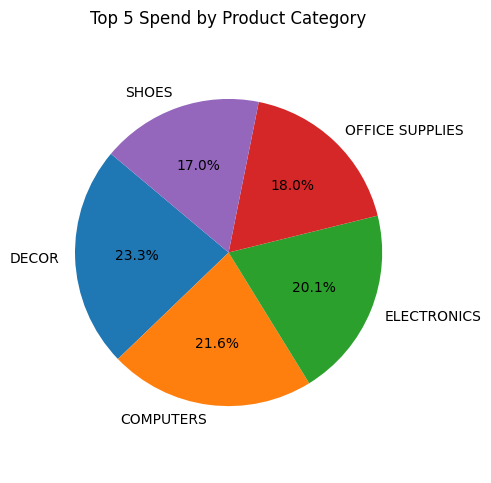

In [12]:
print("=== Spend by Product Category ===")
print(product_summary.head(5), '\n')
# Top 5 by Product Category
top5_product = merged_df.groupby('p_category')['selling_price'].sum().nlargest(5).reset_index()

# Pie Chart - Product Category
plt.figure(figsize=(5, 5))
plt.pie(top5_product['selling_price'], labels=top5_product['p_category'], autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Spend by Product Category')
plt.axis('equal')
plt.tight_layout()
plt.show()

Task 3: Calculate the highest 5 spending in spend category. 

=== Spend by State ===
        state   total_spend  average_spend  transaction_count
1  California  2.140274e+06    2512.058198                852
8       Texas  1.540446e+06    2765.612861                557
9  Washington  6.443487e+05    2801.516117                230
3    Kentucky  6.370890e+05    2769.952239                230
2    Illinois  5.838844e+05    2505.941796                233 



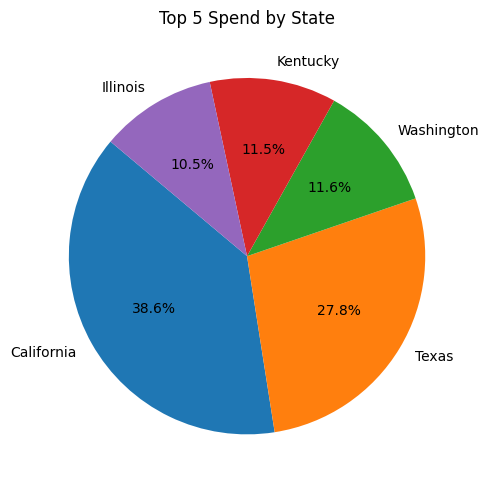

In [13]:
print("=== Spend by State ===")
print(state_summary.head(5), '\n')
# 2. Top 5 by State
top5_state = merged_df.groupby('state')['selling_price'].sum().nlargest(5).reset_index()

# Pie Chart - State
plt.figure(figsize=(5, 5))
plt.pie(top5_state['selling_price'], labels=top5_state['state'], autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Spend by State')
plt.axis('equal')
plt.tight_layout()
plt.show()

Calculate the highest 5 spending in payment method category. 

=== Spend by Payment Method ===
           payment_method   total_spend  average_spend  transaction_count
4  Mobile carrier Billing  3.091968e+06    2576.640163               1200
0             Credit card  2.725746e+06    2578.756904               1057
6            Prepaid card  1.317167e+06    2882.202661                457
1              Debit card  2.491996e+05    2542.853235                 98
5           Paypal wallet  6.008154e+04    2612.240870                 23


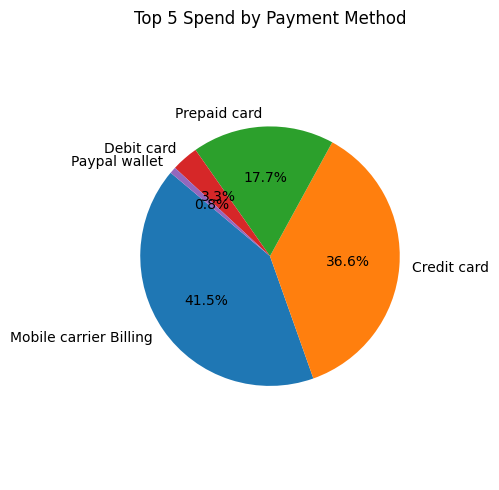

In [14]:
print("=== Spend by Payment Method ===")
print(payment_summary.head(5))

# 3. Top 5 by Payment Method
top5_payment = merged_df.groupby('payment_method')['selling_price'].sum().nlargest(5).reset_index()

# Pie Chart - Payment Method
plt.figure(figsize=(5, 5))
plt.pie(top5_payment['selling_price'], labels=top5_payment['payment_method'], autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Spend by Payment Method')
plt.axis('equal')
plt.tight_layout()
plt.show()

Task 4: Give your opinion on return category like customers returning the products belongs to which state, age group, condition, 
category of the product or is it related to discount. 

In [15]:
# Group by state, summing return indicators (i.e., count of returns)
state_return_count = merged_df.groupby('state')['return_ind'].sum().reset_index().sort_values(by='return_ind', ascending=False)

# Rename column for clarity
state_return_count = state_return_count.rename(columns={'return_ind': 'total_returns'})

# Display
print("=== Total Returns by State ===")
print(state_return_count.to_string(index=False))


# Create age groups
merged_df['age_group'] = pd.cut(merged_df['age'], bins=[17, 25, 35, 50, 70], labels=['18-25','26-35','36-50','51+'])

# Group by age group and count total returns
age_return_count = merged_df.groupby('age_group')['return_ind'].sum().reset_index().sort_values(by='return_ind', ascending=False)
age_return_count = age_return_count.rename(columns={'return_ind': 'total_returns'})

# Display
print("=== Total Returns by Age Group ===")
print(age_return_count.to_string(index=False))

# Group by product category and sum return_ind to get total returns
category_return_count = merged_df.groupby('p_category')['return_ind'].sum().reset_index().sort_values(by='return_ind', ascending=False)
category_return_count = category_return_count.rename(columns={'return_ind': 'total_returns'})

# Display
print("=== Total Returns by Product Category ===")
print(category_return_count.to_string(index=False))

# Group by product condition and count total returns
condition_return_count = merged_df.groupby('condtion')['return_ind'].sum().reset_index().sort_values(by='return_ind', ascending=False)
condition_return_count = condition_return_count.rename(columns={'return_ind': 'total_returns'})

# Display
print("=== Total Returns by Product Condition ===")
print(condition_return_count.to_string(index=False))

# Identify coupon usage
merged_df['used_coupon'] = merged_df['coupon_id'].notna()

# Group by coupon usage and count total returns
coupon_return_count = merged_df.groupby('used_coupon')['return_ind'].sum().reset_index()
coupon_return_count['used_coupon'] = coupon_return_count['used_coupon'].map({True: 'Used Coupon', False: 'No Coupon'})
coupon_return_count = coupon_return_count.rename(columns={'return_ind': 'total_returns'})

# Display
print("=== Total Returns by Coupon Usage ===")
print(coupon_return_count.to_string(index=False))


=== Total Returns by State ===
        state  total_returns
   California            397
        Texas            249
     Kentucky            110
     Illinois            109
   Washington            103
Massachusetts             99
       Nevada             90
      Arizona             88
     Missouri             46
         Ohio             46
=== Total Returns by Age Group ===
age_group  total_returns
      51+            349
    26-35            192
    18-25            114
    36-50             87
=== Total Returns by Product Category ===
      p_category  total_returns
       COMPUTERS            157
           DECOR            155
     ELECTRONICS            140
           SHOES            127
 OFFICE SUPPLIES            108
KITCHEN & DINING            105
        CLOTHING            104
           GAMES             98
         LUGGAGE             80
      APPLIANCES             75
         BEDDING             71
   BABY CLOTHING             62
       BABY TOYS             55


Task 5: Create a profile of customers in terms of timing of their order. 

=== Customer Order Profile by Time of Day ===
  Time of Day  Number of Orders
Early Morning               306
      Morning               649
    Afternoon               568
      Evening               491
        Night               393
     Midnight               467


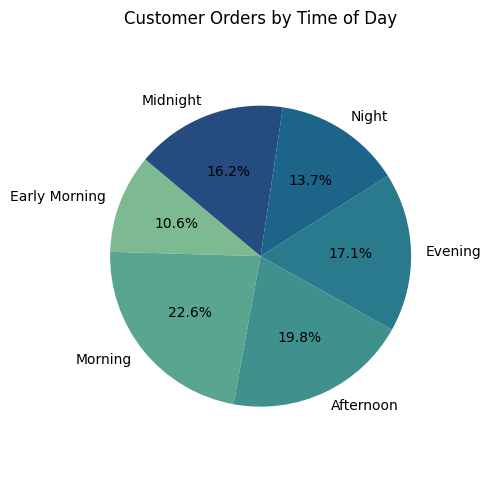

In [16]:
# Example fallback (in case Time is already datetime or string)
# If it's already datetime.time format, just extract the hour
def extract_hour(row):
    try:
        # Try converting to datetime (safe for both HH:MM and HH:MM:SS)
        dt = pd.to_datetime(str(row), format='%H:%M:%S', errors='coerce')
        if pd.isna(dt):
            dt = pd.to_datetime(str(row), format='%H:%M', errors='coerce')
        return dt.hour if pd.notna(dt) else None
    except:
        return None

# Apply the hour extraction
merged_df['hour'] = merged_df['time'].apply(extract_hour)

# Now create time segments
def time_segment(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 4 <= hour < 7:
        return 'Early Morning'
    elif 7 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    elif 21 <= hour < 24:
        return 'Night'
    else:
        return 'Midnight'

merged_df['time_segment'] = merged_df['hour'].apply(time_segment)

# Group and count
time_profile = (
    merged_df['time_segment']
    .value_counts()
    .reindex(['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Midnight'])
    .fillna(0)
    .reset_index()
)
time_profile.columns = ['Time of Day', 'Number of Orders']

# Display
print("=== Customer Order Profile by Time of Day ===")
print(time_profile.to_string(index=False))

# Generate color palette from Seaborn
colors = sns.color_palette('crest', n_colors=len(time_profile))

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    time_profile['Number of Orders'],
    labels=time_profile['Time of Day'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors
)

plt.title('Customer Orders by Time of Day')
plt.axis('equal')  # Makes pie chart circular
plt.tight_layout()
plt.show()

Task 6: Which payment method is providing more discount for customers? 

=== Discount by Payment Method ===
        payment_method  total_discount
Mobile carrier Billing      39378.2045
           Credit card      35136.7720
          Prepaid card      15558.6440
            Debit card       3330.6830
             Gift card        741.6880
         Paypal wallet        644.0000
        Deirect debits        628.6795


C:\Users\Shruti Smriti\AppData\Local\Temp\ipykernel_16896\3003186216.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


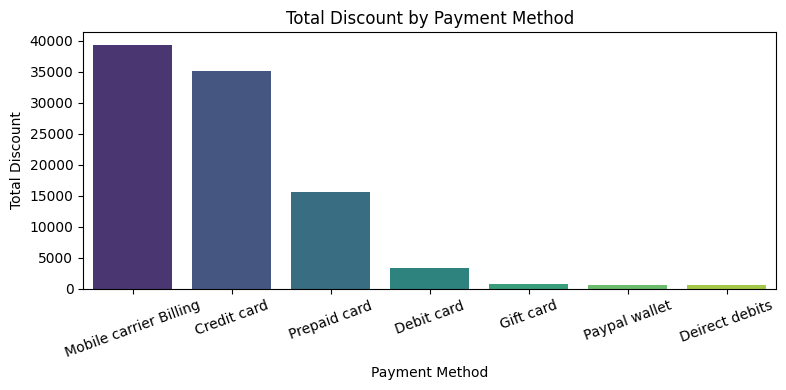

In [17]:
# Calculate discount
merged_df['discount'] = merged_df['price'] - merged_df['selling_price']

# Filter out negative discounts (if any)
merged_df = merged_df[merged_df['discount'] >= 0]

# Group by Payment Method
payment_discount_df = merged_df.groupby('payment_method').agg(
    total_discount=('discount', 'sum')
).reset_index().sort_values(by='total_discount', ascending=False)

# Display the resulting DataFrame
print("=== Discount by Payment Method ===")
print(payment_discount_df.to_string(index=False))

# Set the figure size
plt.figure(figsize=(8, 4))

# Barplot for total discount by payment method
sns.barplot(
    data=payment_discount_df,
    x='payment_method',
    y='total_discount',
    palette='viridis'
)

# Chart labels and title
plt.title('Total Discount by Payment Method')
plt.xlabel('Payment Method')
plt.ylabel('Total Discount')
plt.xticks(rotation=20)
plt.tight_layout()

# Show plot
plt.show()

Task 7: Create a profile for high value items vs low value items and relate that wrt to their number of orders. 

=== High vs Low Value Item Profile ===
Item Value  Number of Orders
High Value              2287
 Low Value               587


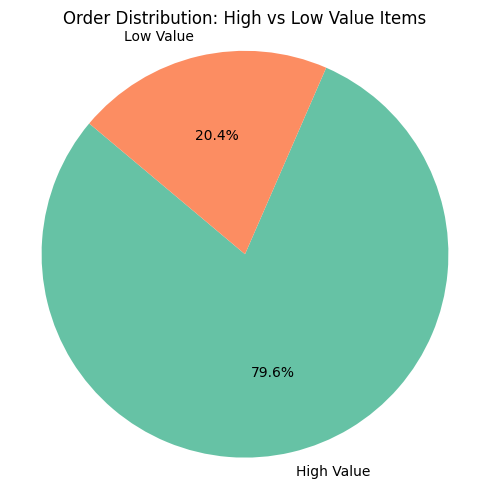

In [18]:
# Create a new column classifying value type
merged_df['item_value'] = merged_df['selling_price'].apply(lambda x: 'High Value' if x > 1000 else 'Low Value')

# Group by item value and count number of orders
value_profile = merged_df['item_value'].value_counts().reset_index()
value_profile.columns = ['Item Value', 'Number of Orders']

# Display the profile
print("=== High vs Low Value Item Profile ===")
print(value_profile.to_string(index=False))

# Create pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    value_profile['Number of Orders'],
    labels=value_profile['Item Value'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['#66c2a5', '#fc8d62']  # Optional color customization
)
plt.title('Order Distribution: High vs Low Value Items')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
plt.tight_layout()
plt.show()


Task 8: Do you think if merchant provides more discount then can it will lead to increase in number of orders? 

In [19]:
# Create a column to identify coupon usage
merged_df['used_coupon'] = merged_df['coupon_id'].notna()

# Count orders per merchant with and without coupons
merchant_discount_data = merged_df.groupby(['merchant_name', 'used_coupon']).size().reset_index(name='order_count')

# Pivot to get side-by-side comparison
merchant_pivot = merchant_discount_data.pivot(index='merchant_name', columns='used_coupon', values='order_count').fillna(0)

# Rename columns
merchant_pivot.columns = ['No_Discount', 'With_Discount']

# Calculate total orders
merchant_pivot['Total_Orders'] = merchant_pivot['No_Discount'] + merchant_pivot['With_Discount']

# Sort by total orders
merchant_pivot = merchant_pivot.sort_values(by='Total_Orders', ascending=False).reset_index()

In [20]:
# Print the output
print("=== Orders With and Without Coupons by Merchant ===")
print(merchant_pivot.to_string(index=False))

=== Orders With and Without Coupons by Merchant ===
     merchant_name  No_Discount  With_Discount  Total_Orders
    Barnes & Noble          2.0          218.0         220.0
              Ulta          0.0          200.0         200.0
        L'Occitane          3.0          193.0         196.0
     Guitar Center          3.0          180.0         183.0
     Cole Hardware          1.0          177.0         178.0
The Vitamin Shoppe          0.0          178.0         178.0
          DODOcase          1.0          164.0         165.0
    The North Face          3.0          161.0         164.0
         Walgreens          2.0          160.0         162.0
               REI          0.0          156.0         156.0
Road Runner Sports          0.0          151.0         151.0
  Peninsula Beauty          1.0          135.0         136.0
          Gymboree          0.0          130.0         130.0
           Staples          1.0          118.0         119.0
       Right Start          0.0  

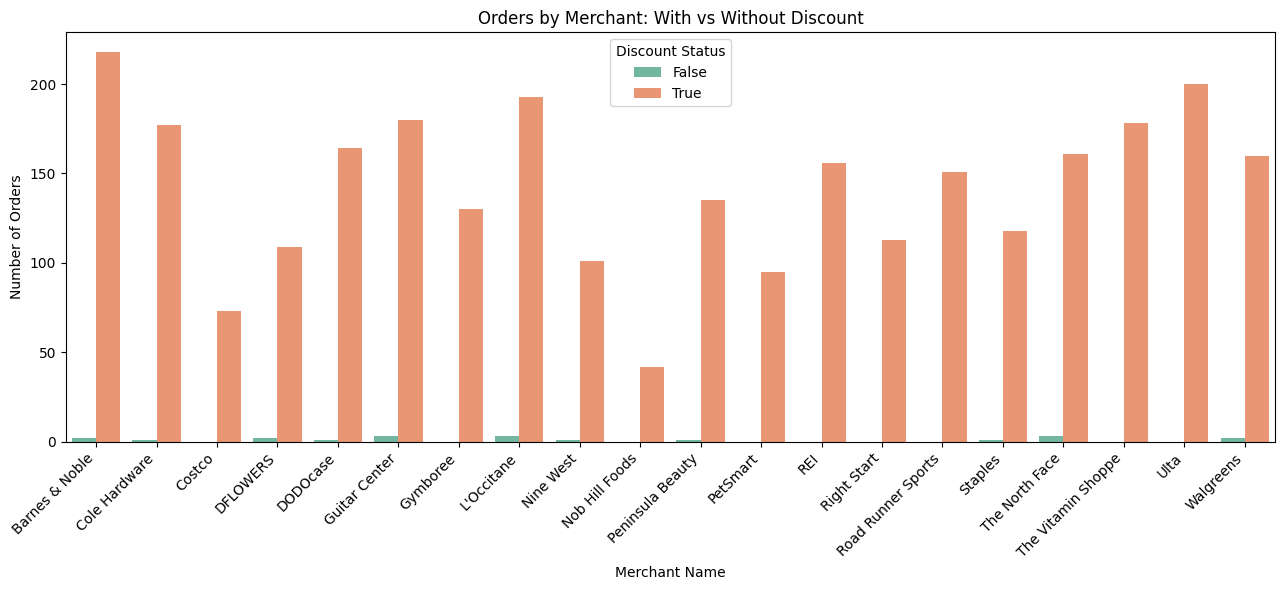

In [21]:
plt.figure(figsize=(13, 6))
sns.barplot(data=merchant_discount_data, x='merchant_name', y='order_count', hue='used_coupon', palette='Set2')
plt.title("Orders by Merchant: With vs Without Discount")
plt.xlabel("Merchant Name")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Discount Status")
plt.tight_layout()
plt.show()
